In [82]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [83]:
df = pd.read_csv('../Data-collection/final_df.csv')
df.head()

,grid,position,year,round,driver_age,driver_experience,driver_constructor_experience,driver_points,driver_standing,constructor_points,...,constructor_mclaren,constructor_mercedes,constructor_racing_point,constructor_rb,constructor_red_bull,constructor_renault,constructor_sauber,constructor_toro_rosso,constructor_virgin,constructor_williams
0,3,1.0,2010,1,28,140,0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,2,2.0,2010,1,28,116,63,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,4,3.0,2010,1,25,52,52,0.0,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False
3,1,4.0,2010,1,22,43,17,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
4,5,5.0,2010,1,24,70,0,0.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,False


In [84]:
# Here the test data needs to be whole races, not random entries from different races
# Will do 3 races per season as test sets
test_races_per_year = 3

# Create a train-test split based on races
unique_races = df[['year', 'round']].drop_duplicates()
test_races = unique_races.groupby('year').sample(n=test_races_per_year, random_state=42)

# Mark test races in the dataset
df['is_test'] = df[['year', 'round']].apply(
    lambda x: tuple(x) in test_races.itertuples(index=False, name=None), axis=1
)

# Split the data
train_df = df[df['is_test'] == False]
test_df = df[df['is_test'] == True]

train_df = train_df.drop(columns=['is_test'])
test_df = test_df.drop(columns=['is_test'])

print(f"Training set size: {len(train_df)}, Testing set size: {len(test_df)}")

Training set size: 4154, Testing set size: 729


In [85]:
X_train = train_df.drop(columns=['position'])
X_test = test_df.drop(columns=['position'])

y_train = train_df['position']
y_test = test_df['position']

print(f"Training Features: {X_train.shape}, Testing Features: {X_test.shape}")
print(f"Training Target: {y_train.shape}, Testing Target: {y_test.shape}")

Training Features: (4154, 146), Testing Features: (729, 146)
Training Target: (4154,), Testing Target: (729,)


In [86]:
# Select only numerical columns for scaling
numerical_columns = [
    'grid', 'driver_age', 'driver_experience', 'driver_constructor_experience',
    'driver_points', 'driver_standing', 'constructor_points', 
    'constructor_standing', 'driver_wins', 'constructor_wins', 'circuit_danger', 
    'year', 'round'
]

scaler = StandardScaler()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# conver one-hot-encoding columns from True/False to 1/0
all_columns = X_train.columns.tolist()
one_hot_columns = [col for col in all_columns if col not in numerical_columns]

X_train[one_hot_columns] = X_train[one_hot_columns].astype(int)
X_test[one_hot_columns] = X_test[one_hot_columns].astype(int)

## Regression Approach

#### Linear Regression

In [87]:
from sklearn.linear_model import LinearRegression
reg_lr_model = LinearRegression()
reg_lr_model.fit(X_train, y_train)
reg_lr_y_test = reg_lr_model.predict(X_test)

#### Random Forest

In [88]:
from sklearn.ensemble import RandomForestRegressor
reg_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
reg_rf_model.fit(X_train, y_train)
reg_rf_y_test = reg_rf_model.predict(X_test)

#### Support Vector Machines (SVM)

In [89]:
from sklearn.svm import SVR
reg_svm_model = SVR(kernel='linear') 
reg_svm_model.fit(X_train, y_train)
reg_svm_y_test = reg_svm_model.predict(X_test)

#### Decision Tree

In [90]:
from sklearn.tree import DecisionTreeRegressor
reg_dt_model = DecisionTreeRegressor()
reg_dt_model.fit(X_train, y_train)
reg_dt_y_test = reg_dt_model.predict(X_test)

#### K-Nearest Neighbor (KNN)

In [91]:
from sklearn.neighbors import KNeighborsRegressor
reg_knn_model = KNeighborsRegressor(n_neighbors=5)
reg_knn_model.fit(X_train, y_train)
reg_knn_y_test = reg_knn_model.predict(X_test)

#### Lasso

In [92]:
from sklearn.linear_model import Lasso
reg_lasso_model = Lasso(alpha=0.1) 
reg_lasso_model.fit(X_train, y_train)
reg_lasso_y_test = reg_lasso_model.predict(X_test)

### Evaluations

In [93]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

reg_models_info = [
    ("Linear Regression", "reg_lr_y_test"),
    ("Random Forest", "reg_rf_y_test"),
    ("SVM", "reg_svm_y_test"),
    ("Decision Tree", "reg_dt_y_test"),
    ("KNN", "reg_knn_y_test"),
    ("Lasso", "reg_lasso_y_test")
]

for model_name, y_test_var_name in reg_models_info:
    y_test_var = globals()[y_test_var_name]

    model_test_mae = mean_absolute_error(y_test, y_test_var)
    model_test_rmse = mean_squared_error(y_test, y_test_var)
    model_test_r2 = r2_score(y_test, y_test_var)

    print(f"---- {model_name} ----")
    print(f" MAE: {model_test_mae:.2f}")
    print(f" RMSE: {model_test_rmse:.2f}")
    print(f" R2: {model_test_r2:.2f}")
    print("")

---- Linear Regression ----
 MAE: 2.34
 RMSE: 9.49
 R2: 0.67

---- Random Forest ----
 MAE: 2.26
 RMSE: 9.01
 R2: 0.68

---- SVM ----
 MAE: 2.30
 RMSE: 9.75
 R2: 0.66

---- Decision Tree ----
 MAE: 3.05
 RMSE: 16.81
 R2: 0.41

---- KNN ----
 MAE: 2.41
 RMSE: 10.18
 R2: 0.64

---- Lasso ----
 MAE: 2.48
 RMSE: 10.31
 R2: 0.64



## Classification Approach

In [94]:
y_train_c = y_train.copy()
y_test_c = y_test.copy()
y_train_c = y_train_c.apply(lambda x: 1 if x == 1 else 0)
y_test_c = y_test_c.apply(lambda x: 1 if x == 1 else 0)

#### Logistic Regression 

In [95]:
from sklearn.linear_model import LogisticRegression
cla_lr_model = LogisticRegression()
cla_lr_model.fit(X_train, y_train_c)
cla_lr_y_test = cla_lr_model.predict(X_test)

#### Decision Tree

In [96]:
from sklearn.tree import DecisionTreeClassifier
cla_dt_model = DecisionTreeClassifier()
cla_dt_model.fit(X_train, y_train_c)
cla_dt_y_test = cla_dt_model.predict(X_test)

#### Support Vector Machines (SVM)

In [97]:
from sklearn.svm import SVC 
cla_svm_model = SVC(kernel='linear')
cla_svm_model.fit(X_train, y_train_c)
cla_svm_y_test = cla_svm_model.predict(X_test)

#### Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier 
cla_rf_model = RandomForestClassifier(n_estimators=100)
cla_rf_model.fit(X_train, y_train_c)
cla_rf_y_test = cla_rf_model.predict(X_test)

#### K-Nearest Neighbor (KNN)

In [99]:
from sklearn.neighbors import KNeighborsClassifier
cla_knn_model = KNeighborsClassifier(n_neighbors=5)
cla_knn_model.fit(X_train, y_train_c)
cla_knn_y_test = cla_knn_model.predict(X_test)

#### Naïve Bayes

In [100]:
from sklearn.naive_bayes import GaussianNB
cla_nb_model = GaussianNB()
cla_nb_model.fit(X_train, y_train_c)
cla_nb_y_test = cla_nb_model.predict(X_test)

### Evaluations

In [101]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

cla_models_info = [
    ("Logistic Regression", "cla_lr_y_test"),
    ("Decision Tree", "cla_dt_y_test"),
    ("SVM", "cla_svm_y_test"),
    ("Random Forest", "cla_rf_y_test"),
    ("KNN", "cla_knn_y_test"),
    ("GaussianNB", "cla_nb_y_test")
]

for model_name, y_test_var_name in cla_models_info:
    y_test_var = globals()[y_test_var_name]

    accuracy = accuracy_score(y_test_c, y_test_var)
    conf_matrix = confusion_matrix(y_test_c, y_test_var)
    class_report = classification_report(y_test_c, y_test_var)

    print(f"---- {model_name} ----")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("")

---- Logistic Regression ----
Accuracy: 0.943758573388203
Confusion Matrix:
[[675  12]
 [ 29  13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       687
           1       0.52      0.31      0.39        42

    accuracy                           0.94       729
   macro avg       0.74      0.65      0.68       729
weighted avg       0.93      0.94      0.94       729


---- Decision Tree ----
Accuracy: 0.9245541838134431
Confusion Matrix:
[[657  30]
 [ 25  17]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       687
           1       0.36      0.40      0.38        42

    accuracy                           0.92       729
   macro avg       0.66      0.68      0.67       729
weighted avg       0.93      0.92      0.93       729


---- SVM ----
Accuracy: 0.9410150891632373
Confusion Matrix:
[[674  13]
 [ 30  12]]
Classification Report

## Deep Learning

### Regression

In [102]:
import tensorflow as tf

dl_reg_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(146,)),  # Input layer with 146 features
    tf.keras.layers.Dense(16, activation='relu'),  # Hidden layer with 32 neurons
    tf.keras.layers.Dense(1, activation='linear')
])

dl_reg_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

dl_reg_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 116.7517 - mean_squared_error: 116.7517 - val_loss: 91.7577 - val_mean_squared_error: 91.7577
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72.7961 - mean_squared_error: 72.7961 - val_loss: 58.6432 - val_mean_squared_error: 58.6432
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.8066 - mean_squared_error: 29.8066 - val_loss: 36.8042 - val_mean_squared_error: 36.8042
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.7500 - mean_squared_error: 17.7500 - val_loss: 26.7720 - val_mean_squared_error: 26.7720
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.8312 - mean_squared_error: 12.8312 - val_loss: 20.8412 - val_mean_squared_error: 20.8412
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.3575 - mean_squared_error: 11.3575 - val_loss: 17.6483 - val_mean_squared_error: 17.6483
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.9588 - mean_squar

In [103]:
dl_reg_y_pred = dl_reg_model.predict(X_test)
dl_reg_r2 = r2_score(y_test, dl_reg_y_pred)
print(f'R² score on test set: {dl_reg_r2}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R² score on test set: 0.5960453193059587


### Classification

In [104]:
import tensorflow as tf

# Define the model
dl_cl_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(146,)),  # Input layer with 146 features
    tf.keras.layers.Dense(32, activation='relu'),  # Additional hidden layer with 64 neurons
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for classification
])

dl_cl_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
dl_cl_model.fit(X_train, y_train_c, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = dl_cl_model.evaluate(X_test, y_test_c)

print(f'Test accuracy: {test_acc}')


Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8297 - loss: 0.4944 - val_accuracy: 0.9362 - val_loss: 0.3225
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9421 - loss: 0.1964 - val_accuracy: 0.9290 - val_loss: 0.2168
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9396 - loss: 0.1553 - val_accuracy: 0.9374 - val_loss: 0.1713
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9495 - loss: 0.1292 - val_accuracy: 0.9446 - val_loss: 0.1481
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9440 - loss: 0.1307 - val_accuracy: 0.9555 - val_loss: 0.1327
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9508 - loss: 0.1232 - val_accuracy: 0.9591 - val_loss: 0.1215
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9449 - loss: 0.1228 - val_accuracy: 0.9531 - val_loss: 0.1164
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9508 - loss: 0.1144 - val_accu

In [105]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

dl_cl_y_pred_prob = dl_cl_model.predict(X_test)

dl_cl_y_pred = (dl_cl_y_pred_prob > 0.6).astype("int32")

dl_cl_accuracy = accuracy_score(y_test_c, dl_cl_y_pred)
dl_cl_conf_matrix = confusion_matrix(y_test_c, dl_cl_y_pred)
dl_cl_class_report = classification_report(y_test_c, dl_cl_y_pred)

print(f"Accuracy: {dl_cl_accuracy}")
print("Confusion Matrix:")
print(dl_cl_conf_matrix)
print("Classification Report:")
print(dl_cl_class_report)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
Accuracy: 0.9327846364883402
Confusion Matrix:
[[671  16]
 [ 33   9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       687
           1       0.36      0.21      0.27        42

    accuracy                           0.93       729
   macro avg       0.66      0.60      0.62       729
weighted avg       0.92      0.93      0.92       729



# Metrics

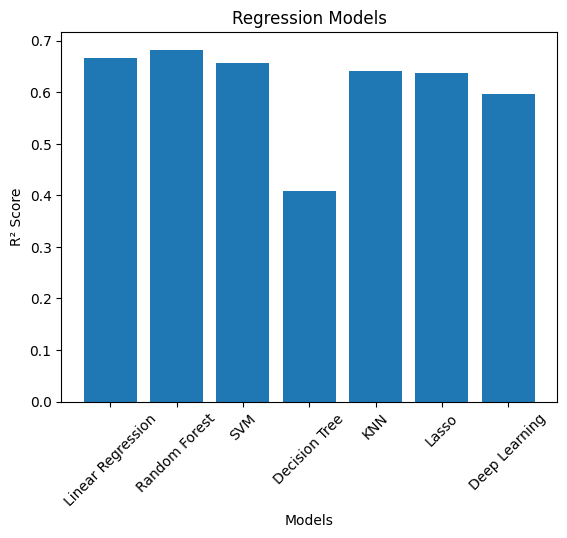

In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

reg_models_info = [
    ("Linear Regression", "reg_lr_y_test"),
    ("Random Forest", "reg_rf_y_test"),
    ("SVM", "reg_svm_y_test"),
    ("Decision Tree", "reg_dt_y_test"),
    ("KNN", "reg_knn_y_test"),
    ("Lasso", "reg_lasso_y_test"),
    ("Deep Learning", "dl_reg_y_pred")
]

reg_r2_scores = []
reg_model_names = []

for model_name, y_test_var_name in reg_models_info:
    y_test_var = globals()[y_test_var_name]

    r2 = r2_score(y_test, y_test_var)
    reg_r2_scores.append(r2)
    reg_model_names.append(model_name)

plt.bar(reg_model_names, reg_r2_scores)
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Regression Models')
plt.xticks(rotation=45)
plt.show()

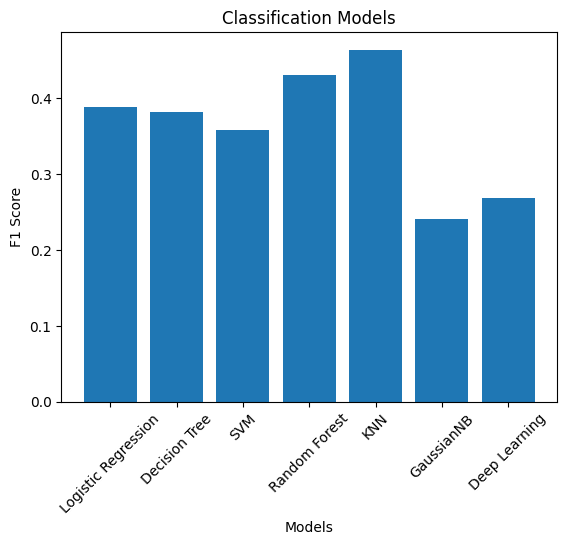

In [107]:
from sklearn.metrics import f1_score

cla_models_info = [
    ("Logistic Regression", "cla_lr_y_test"),
    ("Decision Tree", "cla_dt_y_test"),
    ("SVM", "cla_svm_y_test"),
    ("Random Forest", "cla_rf_y_test"),
    ("KNN", "cla_knn_y_test"),
    ("GaussianNB", "cla_nb_y_test"),
    ("Deep Learning", "dl_cl_y_pred")
]

cl_f1_scores = []
cl_model_names = []

for model_name, y_test_var_name in cla_models_info:
    y_test_var = globals()[y_test_var_name]

    f1 = f1_score(y_test_c, y_test_var, pos_label=1)
    cl_f1_scores.append(f1)
    cl_model_names.append(model_name)
    

plt.bar(cl_model_names, cl_f1_scores)
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Classification Models')
plt.xticks(rotation=45)
plt.show()

## Save The model

In [108]:
import joblib

joblib.dump(reg_rf_model, 'trained_model.pkl')

['trained_model.pkl']